In [7]:
%load_ext autoreload
%autoreload 2

import pickle
from pathlib import Path

import keras_tuner
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from keras.src.layers import Dropout
from keras.src.layers import Dense
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from src.metrics.ece import ece

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def interpolate_indexed_value_array(indexing_array: np.ndarray, value_array: np.ndarray, searched_for, strategy="linear"):
    f = interp1d(indexing_array, value_array, kind=strategy,
                 bounds_error=False, fill_value=(value_array[0], value_array[-1]))
    return f(searched_for)


def safe_unpickle_all(file):
    objects = []
    unpickler = pickle.Unpickler(file)
    while True:
        try:
            obj = unpickler.load()
            objects.append(obj)
        except EOFError:
            break  # End of file (incomplete last object)
        except Exception as e:
            print("Partial data recovered. Stopped at error:", e)
            break
    return objects

def build_nn(hp) -> keras.Model:
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    for i in range(hp.Int('num_layers', 5, 14)):
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=256, max_value=1536, step=32),
                activation=hp.Choice(f"activation_{i}", ["relu", "linear"]),
            )
        )
    model.add(Dense(1, activation="relu"))
    model.add(Dropout(hp.Float("Dropout", 0.05, 0.25, sampling='log')))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-5, 5e-4, sampling='log')

    optimizer = None
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.LogCosh,
        metrics=["mae", "mse"],
    )
    return model

def get_rounded_clipped_sample_size(sample_size):
    return max(15, min(10000, round(sample_size)))

def calculate_ece_on_subsets(p_pred, y_true, sample_size, num=10):
    eces = []
    for i in range(num):
        indices = np.random.choice(p_pred.shape[0], size=get_rounded_clipped_sample_size(sample_size), replace=True)
        p_pred_subset = p_pred[indices]
        y_true_subset = y_true[indices]
        eces.append(ece(p_pred_subset, y_true_subset, 15))
    return np.array(eces)
        

In [9]:
# Gather Data from different files
print("Gathering data...")
data = []
dirs = ["./data/20250521_210111", "./data/20250522_001733"]

for dir in dirs:
    files = Path(dir).glob("*.pkl")
    for file_name in files:
        print(file_name, sep=", ")
        with (open(f'{file_name}', 'rb') as file):
            try:
                content = pickle.load(file)
            except EOFError:
                print("Data is corrupted. Trying to partially recover data...")
                content = safe_unpickle_all(file)
                print(content)

            data = data + content

Gathering data...
data\20250521_210111\batch_0.pkl
data\20250522_001733\batch_0.pkl
data\20250522_001733\batch_1.pkl
data\20250522_001733\batch_2.pkl
data\20250522_001733\batch_3.pkl
data\20250522_001733\batch_4.pkl
data\20250522_001733\batch_5.pkl
data\20250522_001733\batch_6.pkl
data\20250522_001733\batch_7.pkl
data\20250522_001733\batch_8.pkl


In [10]:
model_results = []
y_tests = []
p_tests = []
eces = []
sample_sizes = []
accuracies = []
y = []
optimal_eces = []
for result in data:
    model_result = result["model_results"]
    model_results = model_results + model_result
    
    for r in model_result:
        p_tests.append(r["p_test"])
        eces.append(r["ECEs"])
        accuracies.append(r["Accuracy"])
        y.append(r["Optimal Sample Size"])
        optimal_eces.append(r["Optimal ECE"])

    for i in range(4):
        y_tests.append(result["y_test"])
        sample_sizes.append(result["Sample Sizes"])

# Ensure numpy
y_tests = np.array(y_tests)
eces = np.array(eces)
p_tests = np.array(p_tests, dtype=np.float32)
sample_sizes = np.array(sample_sizes)
accuracies = np.array(accuracies)
y = np.array(y)
optimal_eces = np.array(optimal_eces)

mean_accuracy = np.mean(accuracies)
std_dev_accuracy = np.std(accuracies)

dist_from_eces0 = np.array([np.linalg.norm(eces[0] - eces[i]) for i in range(len(eces)) if i != 0])

In [11]:
print("y_tests shape", y_tests.shape)
print("sample sizes shape", sample_sizes.shape)
print("p_tests shape", p_tests.shape)
print("eces shape", eces.shape)
print("Mean Accuracy", mean_accuracy)
print("Std. Dev. Accuracy", std_dev_accuracy)
print("Distances from eces[0]", dist_from_eces0)
print("Mean distance from eces[0]", np.mean(dist_from_eces0))
print("Std. Dev distance from eces[0]", np.std(dist_from_eces0))

print("Mean True ECE", np.mean(np.array([result["True ECE Dists (Binned - 15 Bins)"] for result in model_results])))
print("Std. Dev True ECE", np.std(np.array([result["True ECE Dists (Binned - 15 Bins)"] for result in model_results])))

print(sample_sizes)
print(eces)

y_tests shape (960, 10000)
sample sizes shape (960, 100)
p_tests shape (960, 10000, 2)
eces shape (960, 100)
Mean Accuracy 0.6053810416666666
Std. Dev. Accuracy 0.10028754043041237
Distances from eces[0] [0.12261023 0.12739324 0.13183932 0.22342691 0.17580058 0.18244214
 0.10181755 0.19983683 0.10447829 0.21557449 0.19946224 0.12188603
 0.16336047 0.1608856  0.12069146 0.18758008 0.15011331 0.11125344
 0.1525552  0.1899746  0.13967525 0.21417855 0.19122741 0.14739673
 0.14149353 0.1048243  0.09705406 0.16983064 0.1412814  0.2032131
 0.345248   0.20745026 0.12374104 0.19340817 0.42680827 0.21994755
 0.16444154 0.213836   0.17928624 0.26157188 0.23045476 0.2100417
 0.24183936 0.10805812 0.10723344 0.14835173 0.10363037 0.19730179
 0.1887241  0.11398186 1.1478914  0.17314245 0.14975271 0.14763132
 0.12701007 0.14571914 0.05815716 0.16977341 0.09561313 0.14452217
 0.10553335 0.12189168 0.11231114 0.17065479 0.11614315 0.17643807
 0.07019489 0.21898912 0.17487549 0.20469467 0.23295964 0.186

In [12]:
# Prepare Data
X = np.hstack((sample_sizes, eces, accuracies.reshape(-1, 1)))
y = np.column_stack((y, optimal_eces))

print(X)

[[1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 2.19966201e-02
  2.19608029e-02 5.83000000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 1.51022090e-02
  1.52853013e-02 5.86800000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 1.25496412e-02
  1.25134522e-02 5.88100000e-01]
 ...
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 7.43674023e-03
  8.08129005e-03 5.50900000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 6.59240961e-03
  6.86846212e-03 5.52700000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 7.62383838e-02
  7.57800000e-02 5.31500000e-01]]


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

optimal_eces_train = y_train[:, 1]
y_train = y_train[:, 0]
optimal_eces_test = y_test[:, 1]
y_test = y_test[:, 0]

X_train = X_train[:, 100:]
X_test = X_test[:, 100:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

print("y_train Shape", y_train.shape)
print("y_test Shape", y_test.shape)


X_train Shape (768, 101)
X_test Shape (192, 101)
y_train Shape (768,)
y_test Shape (192,)


In [14]:
# Perform Bayes Optimization
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_nn,
    objective="val_loss",
    max_trials=24,
    executions_per_trial=1,
    directory="keras_tuner_logs_bayes_logcosh_dropout_only_ece_values_ext",
    project_name="ece_neural_network_bayes2_logscosh_dropout_only_ece_values_ext",
)
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=128,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

best_model = tuner.get_best_models(num_models=1)[0]
y_pred_scaled = np.array(best_model.predict(X_test)).flatten()
y_pred = y_pred_scaled
print("y_pred_scaled NN", y_pred_scaled)

# Print best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key in best_hps.values.keys():
    print(f"{key}: {best_hps.get(key)}")

"""
model = keras.Sequential()
model.add(keras.layers.Flatten())
for i in range(4):
    model.add(
        Dense(
            units=480,
            activation="relu",
        )
    )
model.add(Dense(1, activation="linear"))

learning_rate = 0.0022035143136497045

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.LogCosh(),
    metrics=["mae"],
)

model.fit(X_train_scaled, y_train_scaled)
y_pred = y_scaler.inverse_transform(np.array(model.predict(X_test_scaled)).flatten().reshape(-1, 1)).ravel()
"""

print("y_pred NN", y_pred)

Trial 24 Complete [00h 01m 19s]
val_loss: 1597.6470947265625

Best val_loss So Far: 1541.6068115234375
Total elapsed time: 00h 27m 04s


D:\ProgrammingProjects\PyCharm\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
y_pred_scaled NN [ 1152.6342   7320.869    2514.1921   2289.8179   1642.7234   2822.2566
  7097.131    4488.709    4652.6475   2113.625    7743.573    1262.8218
  5053.8213    523.85895  6782.3135   1678.049    4903.1406   1362.6903
  1835.3331   1495.2526    913.8535    978.1988  12481.177    2790.8018
  5065.674     543.7078   2460.734    2488.803    4281.1465   1434.4683
  2099.5156    290.56396  3547.104    4303.0225   5201.09     1390.9417
  1088.7052   1214.2676   1883.7793   3315.0957   2911.005    1085.0729
  5340.3774   3067.1182   1724.9578    928.68085  3265.1074   1635.0071
  1558.7328   2154.3154    896.9218   4115.9985   3809.4575   4547.195
  4517.927     367.2489    434.71106   906.4346   2329.7864   1627.0468
  7581.5195   1327.0255   1465.3527   3510.4353   3696.2175   1703.0079
   690.4233   3821.2737   1638.712     143.6236    890.84576  5195.373
  2338.186    7808.843    4640.6787   2529.0945    792.2946   5848.621
  4320.686  

In [15]:
# Train Regressor
model = XGBRegressor(
    n_estimators=1000,
    max_depth=16,
    learning_rate=0.002,
    subsample=0.78,
    colsample_bytree=0.75,
    gamma=1,
    reg_alpha=0.15,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)
model.fit(X_train, y_train)
y_pred_scaled_regressor = np.array(model.predict(X_test)).flatten()
y_pred_regressor = y_pred_scaled_regressor
print("y_pred_scaled regressor", y_pred_scaled_regressor)
print("y_pred_regressor", y_pred_regressor)

y_pred_scaled regressor [1580.9647  5353.1626  3880.2544  3604.4297  3146.8008  3957.8384
 6030.219   4825.267   5900.531   3701.384   6369.1216  1918.6252
 4595.1206  1197.3076  6986.743   2678.0063  5662.266   2292.1372
 3140.1023  2737.5457  1944.7097  1671.7596  6206.5376  4523.0786
 4509.3037  1625.4816  2115.3694  4616.7183  4857.246   2312.3984
 2998.663    749.9489  4174.9473  5968.0073  7137.3057  1369.8236
 2052.001   2352.5793  3484.7554  2695.4539  3770.3306  3444.0217
 5078.4688  3034.985   2369.981   3697.341   3557.5793  2788.6626
 2868.3716  3251.2158  2234.3376  4393.624   5656.2695  5038.6104
 4037.5332   716.3961  2479.9663  1995.7577  1847.4043  2906.1577
 4960.81    1104.986   2576.4062  4965.066   6373.834   3130.9558
 1881.6238  5131.485   2160.8455   778.34875 1707.6826  4808.5845
 3069.5962  5541.242   5554.1123  3759.2532  2962.2043  5126.8286
 4288.1567  5727.0156  3507.9456  1757.0992  5250.795   5734.547
 3379.1672  5110.165   2891.4807  2258.5771  4064.128

In [26]:
# Calculate Metrics and display Dataframe
print("X_test", X_test)
X_test_eces = X_test[:, :100]
print("X_test_eces", X_test_eces)
print("Sample Sizes", sample_sizes)


simple_strategy_preds = [
    (f"{(i + 1) * 100} Samples", (sample_sizes[len(X_train):, i], X_test_eces[:, i])) for i in [0, 4, 9, 19, 49, 79, 99]]

preds = {}
for pred in simple_strategy_preds:
    preds[pred[0]] = pred[1]
    

num_ece_subsets = 100


ece_nn_interpolated = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size) for
                                (i, sample_size) in enumerate(y_pred)])


ece_regressor_interpolated = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size) for
                      (i, sample_size) in enumerate(y_pred_regressor)])

ece_nn_interpolated_quad = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size, strategy="quadratic") for
                      (i, sample_size) in enumerate(y_pred)])

ece_regressor_interpolated_quad = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size, strategy="quadratic") for
                                      (i, sample_size) in enumerate(y_pred_regressor)])
preds.update({
    "Neural Network": (
        y_pred, np.array([ece(p_tests[i][:get_rounded_clipped_sample_size(sample_size)], y_tests[i][:get_rounded_clipped_sample_size(sample_size)], n_bins=15) for
                          i, sample_size in enumerate(y_pred)])),
    "XGBRegressor": (y_pred_regressor,
                     np.array([ece(p_tests[i][:get_rounded_clipped_sample_size(sample_size)], y_tests[i][:get_rounded_clipped_sample_size(sample_size)], n_bins=15) for
                               i, sample_size in enumerate(y_pred_regressor)])),
    f"Neural Network (ECE on subsets {num_ece_subsets})": (
        y_pred, np.array([np.mean(calculate_ece_on_subsets(p_tests[i], y_tests[i], sample_size, num_ece_subsets)) for i, sample_size in enumerate(y_pred)])),
    f"XGBRegressor (ECE on subsets {num_ece_subsets})": (
        y_pred_regressor, np.array([np.mean(calculate_ece_on_subsets(p_tests[i], y_tests[i], sample_size, num_ece_subsets)) for i, sample_size in enumerate(y_pred_regressor)])),
    "Neural Network (Interpolated)": (y_pred, ece_nn_interpolated),
    "XGBRegressor (Interpolated)": (y_pred_regressor, ece_regressor_interpolated),
    "Interpolated Average": ((y_pred + y_pred_regressor)/ 2, (ece_nn_interpolated + ece_regressor_interpolated) / 2),
    "Neural Network (Interpolated - Quadratic)": (y_pred, ece_nn_interpolated_quad),
    "XGBRegressor (Interpolated - Quadratic)": (y_pred_regressor, ece_regressor_interpolated_quad),
    "Interpolated (Quadratic) Average": ((y_pred + y_pred_regressor) / 2, (ece_nn_interpolated_quad + ece_regressor_interpolated_quad) / 2),
    "Y_Test": (y_test, optimal_eces_test)
})

print("Optimal ECEs", optimal_eces_test)
print("y_test", y_test)
# Compute stats
results = []
for name, (sample_sizes_, eces) in preds.items():
    print(name, sample_sizes_, eces)
    results.append({
        "Name": name,
        "Mean (Samples)": np.mean(sample_sizes_),
        "Std Dev (Samples)": np.std(sample_sizes_),
        "MSE (Samples)": mean_squared_error(y_test, sample_sizes_),
        "MAE (Samples)": mean_absolute_error(y_test, sample_sizes_),
        "R2-Score (Samples)": r2_score(y_test, sample_sizes_),
        "Mean (ECE)": np.mean(eces),
        "Std Dev (ECE)": np.std(eces),
        "MSE (ECE)": mean_squared_error(optimal_eces_test, eces),
        "MAE (ECE)": mean_absolute_error(optimal_eces_test, eces),
        "R2-Score (ECE)": r2_score(optimal_eces_test, eces),
    })

# Create DataFrame
pd.set_option('display.max_columns', None)
df = pd.DataFrame(results)
print(df) 

X_test [[0.04650323 0.0406802  0.04074432 ... 0.02265949 0.02243572 0.909     ]
 [0.08445606 0.07385967 0.05442503 ... 0.01569864 0.01601127 0.7197    ]
 [0.063243   0.07112318 0.06557187 ... 0.00882551 0.00916315 0.6781    ]
 ...
 [0.05591424 0.04167473 0.04323823 ... 0.0186979  0.01924208 0.5839    ]
 [0.138      0.07595    0.0771     ... 0.05253131 0.052859   0.5136    ]
 [0.11437934 0.0879033  0.04286162 ... 0.00187802 0.00200859 0.5337    ]]
X_test_eces [[0.04650323 0.0406802  0.04074432 ... 0.02289417 0.02265949 0.02243572]
 [0.08445606 0.07385967 0.05442503 ... 0.01554697 0.01569864 0.01601127]
 [0.063243   0.07112318 0.06557187 ... 0.00914237 0.00882551 0.00916315]
 ...
 [0.05591424 0.04167473 0.04323823 ... 0.01879046 0.0186979  0.01924208]
 [0.138      0.07595    0.0771     ... 0.05265204 0.05253131 0.052859  ]
 [0.11437934 0.0879033  0.04286162 ... 0.00221464 0.00187802 0.00200859]]
Sample Sizes [[  100   200   300 ...  9800  9900 10000]
 [  100   200   300 ...  9800  9900 1

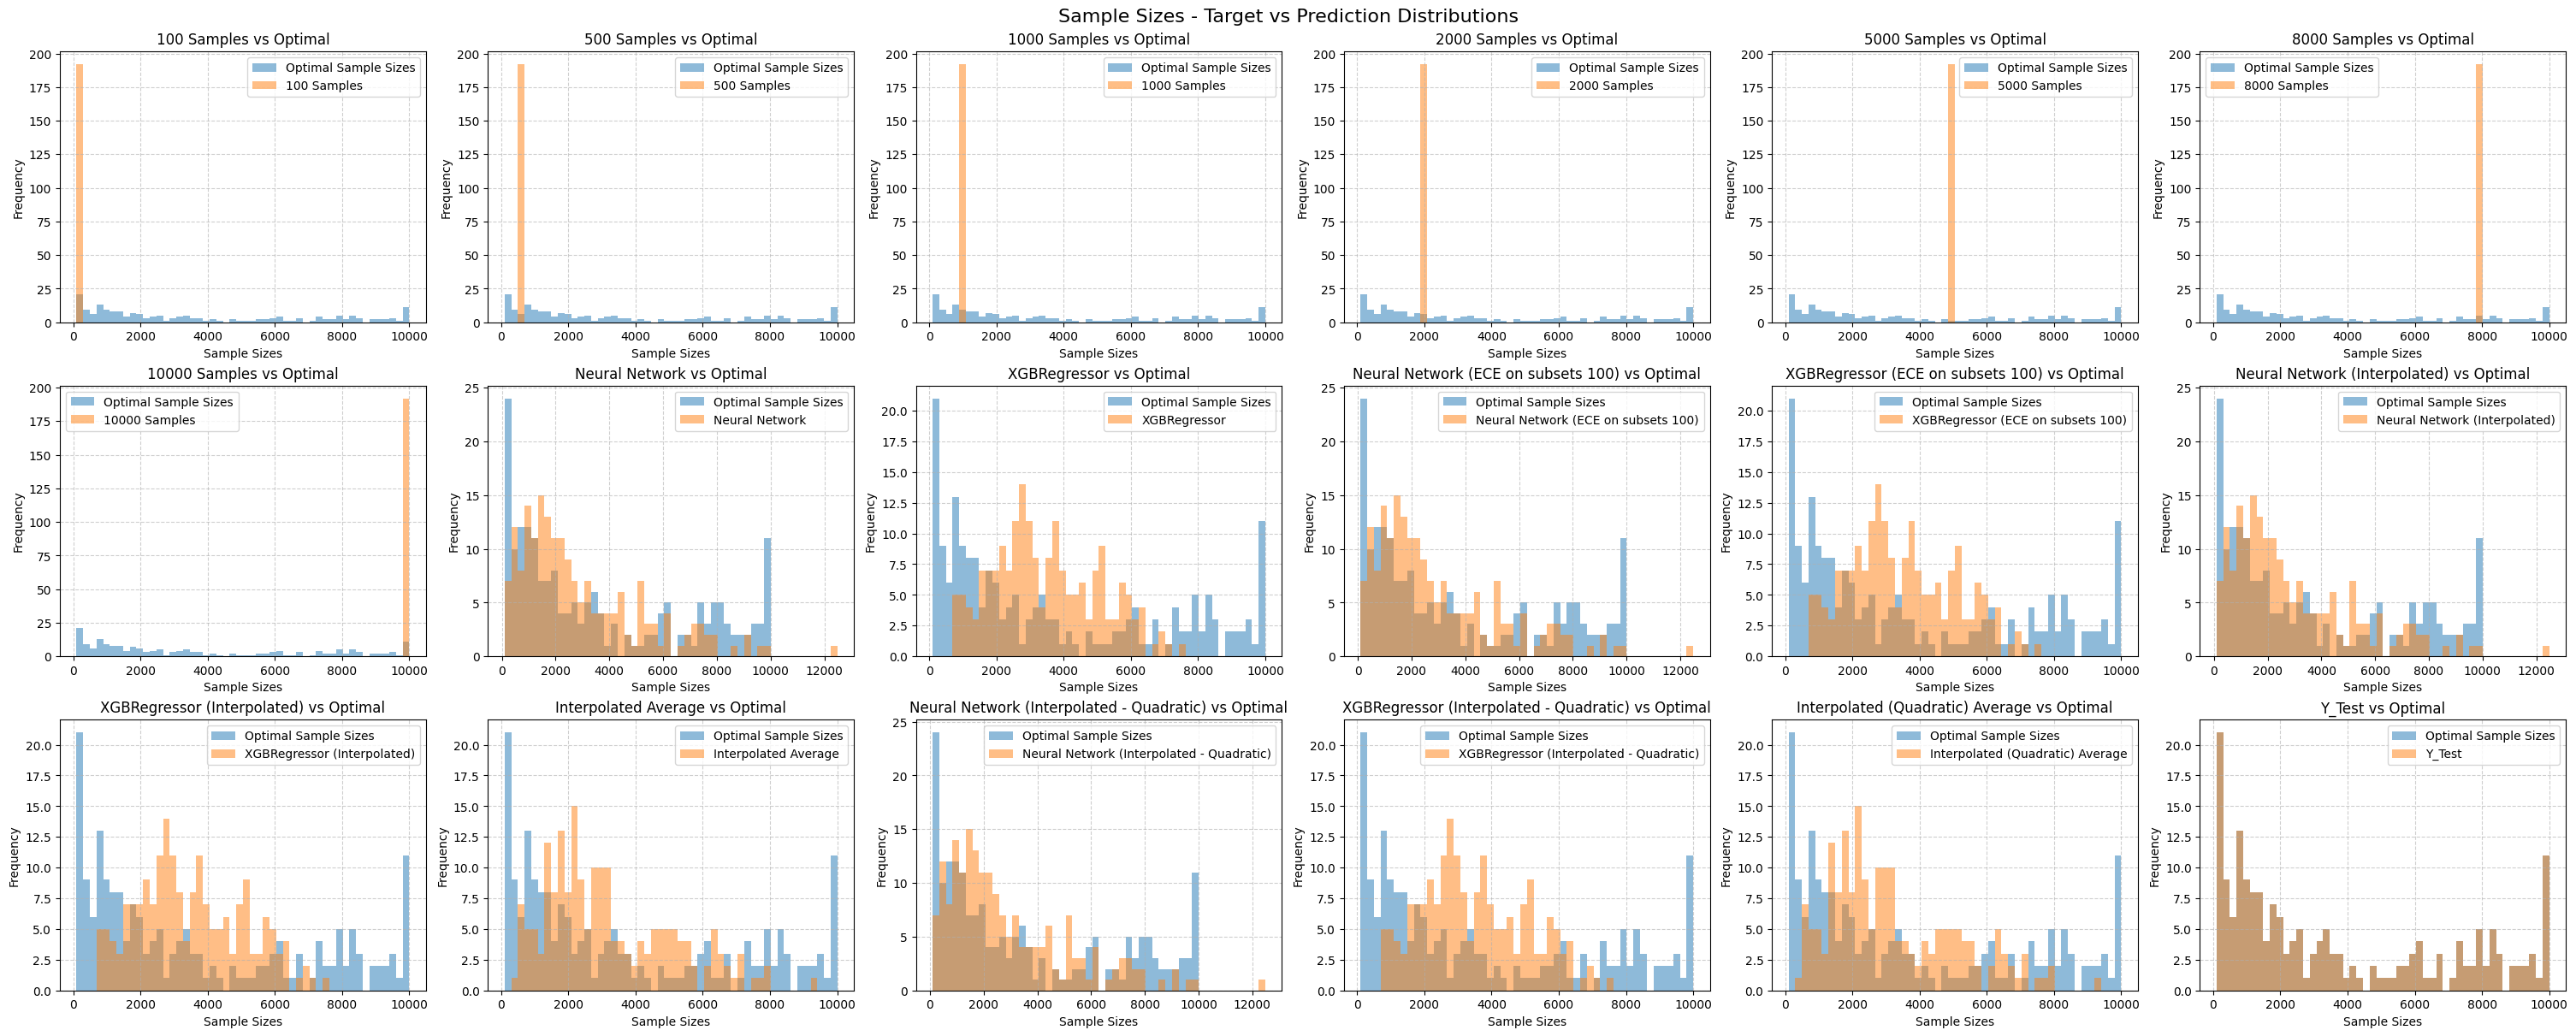

In [43]:
num_preds = len(preds)
cols = 6  # You can change this
rows = int(np.ceil(num_preds / cols))

fig, axs = plt.subplots(rows, cols, figsize=(30, 4 * rows), constrained_layout=True)

# Flatten axes array for easy indexing
axs = axs.flatten()

# Plot each prediction vs. optimal
for i, (key, value) in enumerate(preds.items()):
    ax = axs[i]
    pred_sample_sizes = value[0]
    bin_range = (min(y_test.min(), pred_sample_sizes.min()), max(y_test.max(), pred_sample_sizes.max()))
    ax.hist(y_test, bins=50, range=bin_range, alpha=0.5, label="Optimal Sample Sizes")
    ax.hist(pred_sample_sizes, bins=50, range=bin_range, alpha=0.5, label=key)
    ax.set_title(f"{key} vs Optimal")
    ax.set_xlabel("Sample Sizes")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Sample Sizes - Target vs Prediction Distributions", fontsize=16)
plt.savefig("./optimal_ece_estimator_sample_sizes_distribution_comparison")
plt.show()

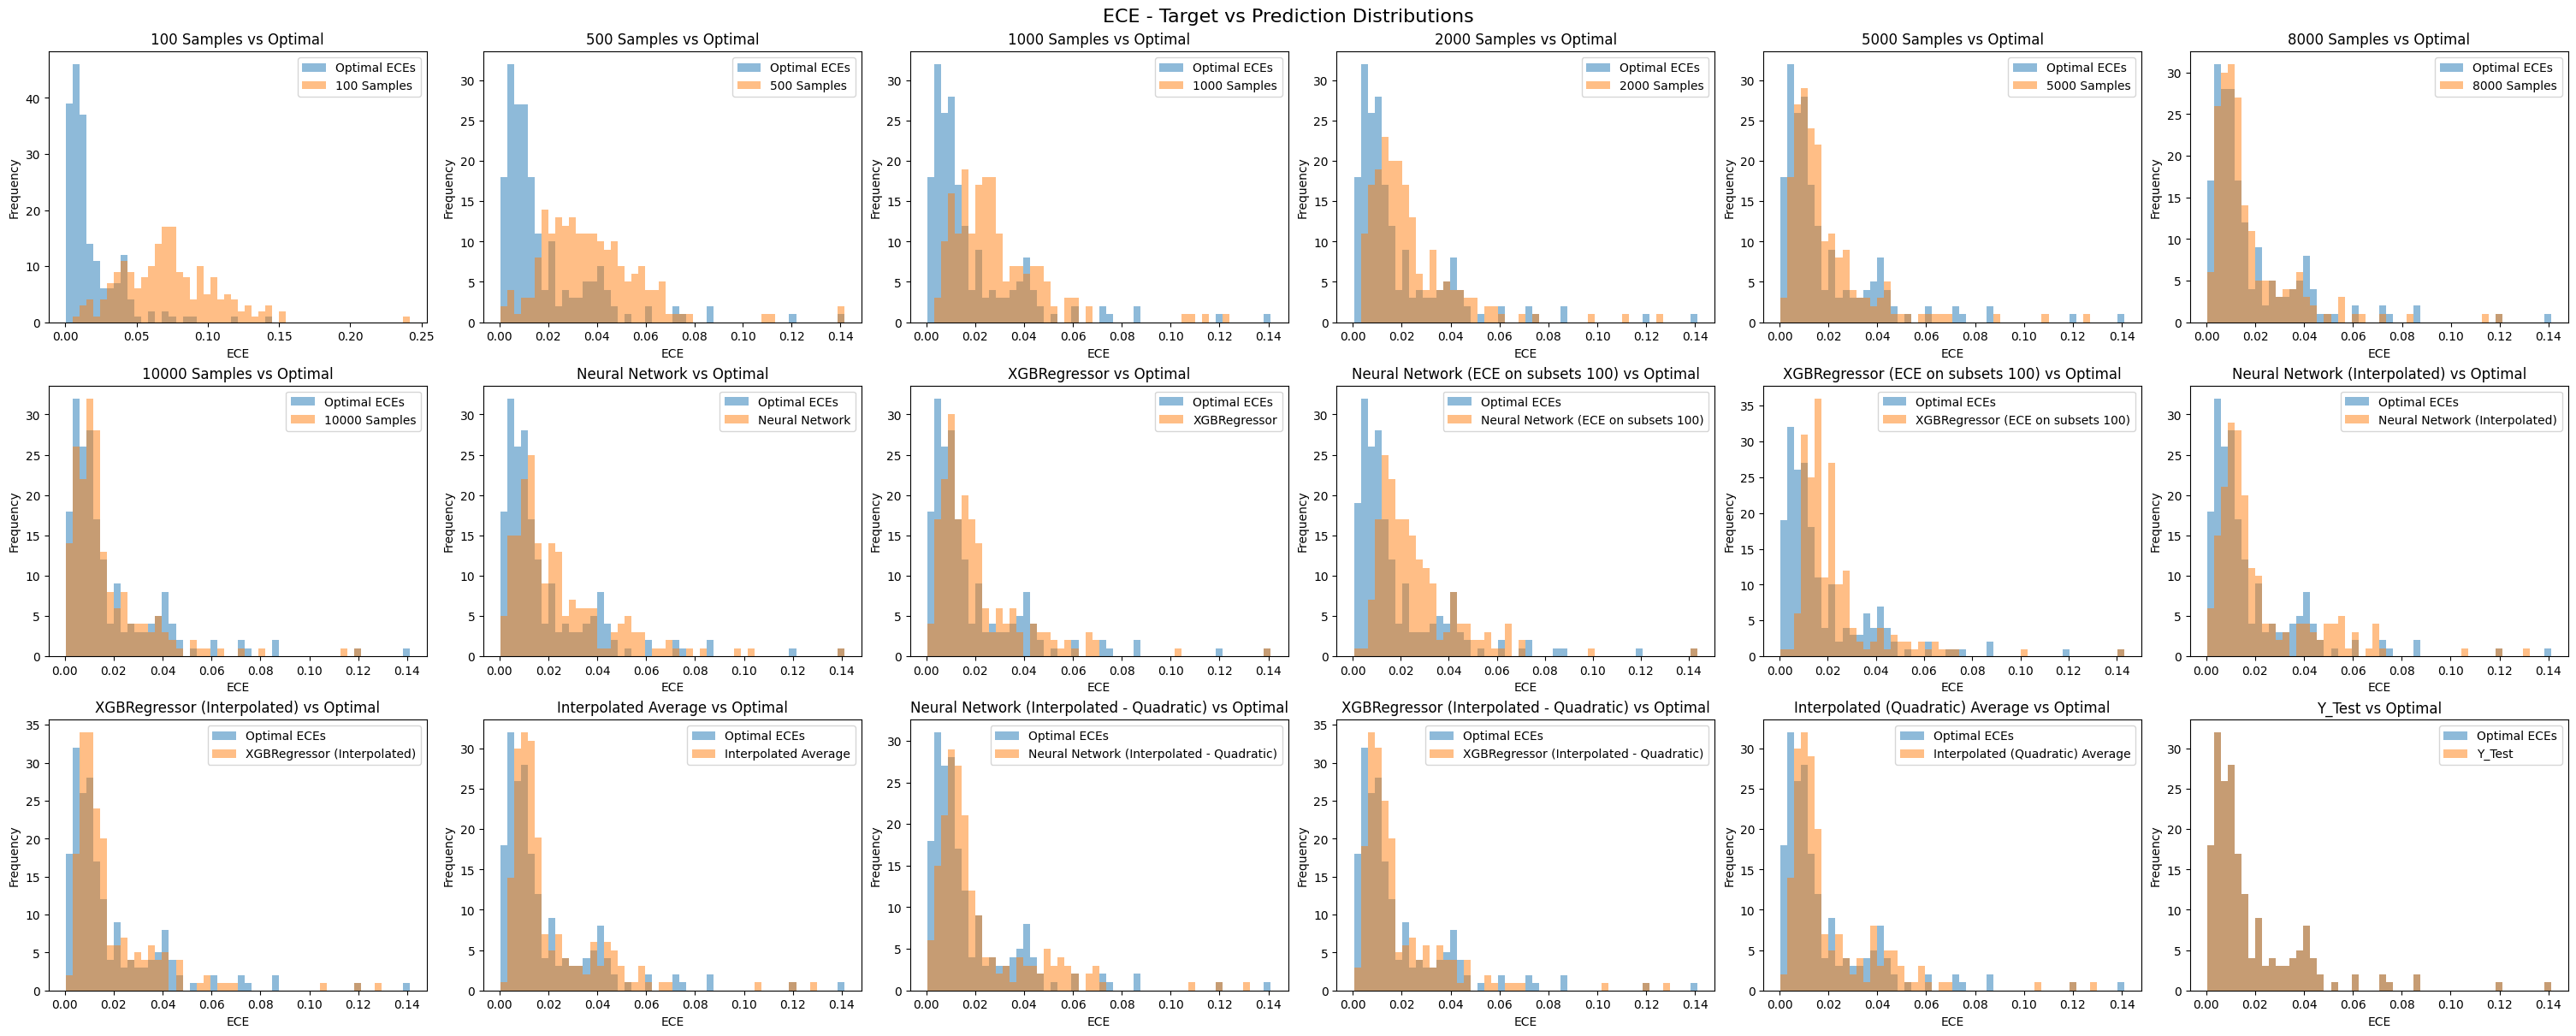

In [44]:
num_preds = len(preds)
cols = 6  # You can change this
rows = int(np.ceil(num_preds / cols))

fig, axs = plt.subplots(rows, cols, figsize=(30, 4 * rows), constrained_layout=True)

# Flatten axes array for easy indexing
axs = axs.flatten()

# Plot each prediction vs. optimal
for i, (key, value) in enumerate(preds.items()):
    ax = axs[i]
    pred_eces = value[1]
    bin_range = (min(optimal_eces_test.min(), pred_eces.min()), max(optimal_eces_test.max(), pred_eces.max()))
    ax.hist(optimal_eces_test, bins=50, range=bin_range, alpha=0.5, label="Optimal ECEs")
    ax.hist(pred_eces, bins=50, range=bin_range, alpha=0.5, label=key)
    ax.set_title(f"{key} vs Optimal")
    ax.set_xlabel("ECE")
    ax.set_ylabel("Frequency")
    ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("ECE - Target vs Prediction Distributions", fontsize=16)
plt.savefig("./optimal_ece_estimator_ece_distribution_comparison")
plt.show()

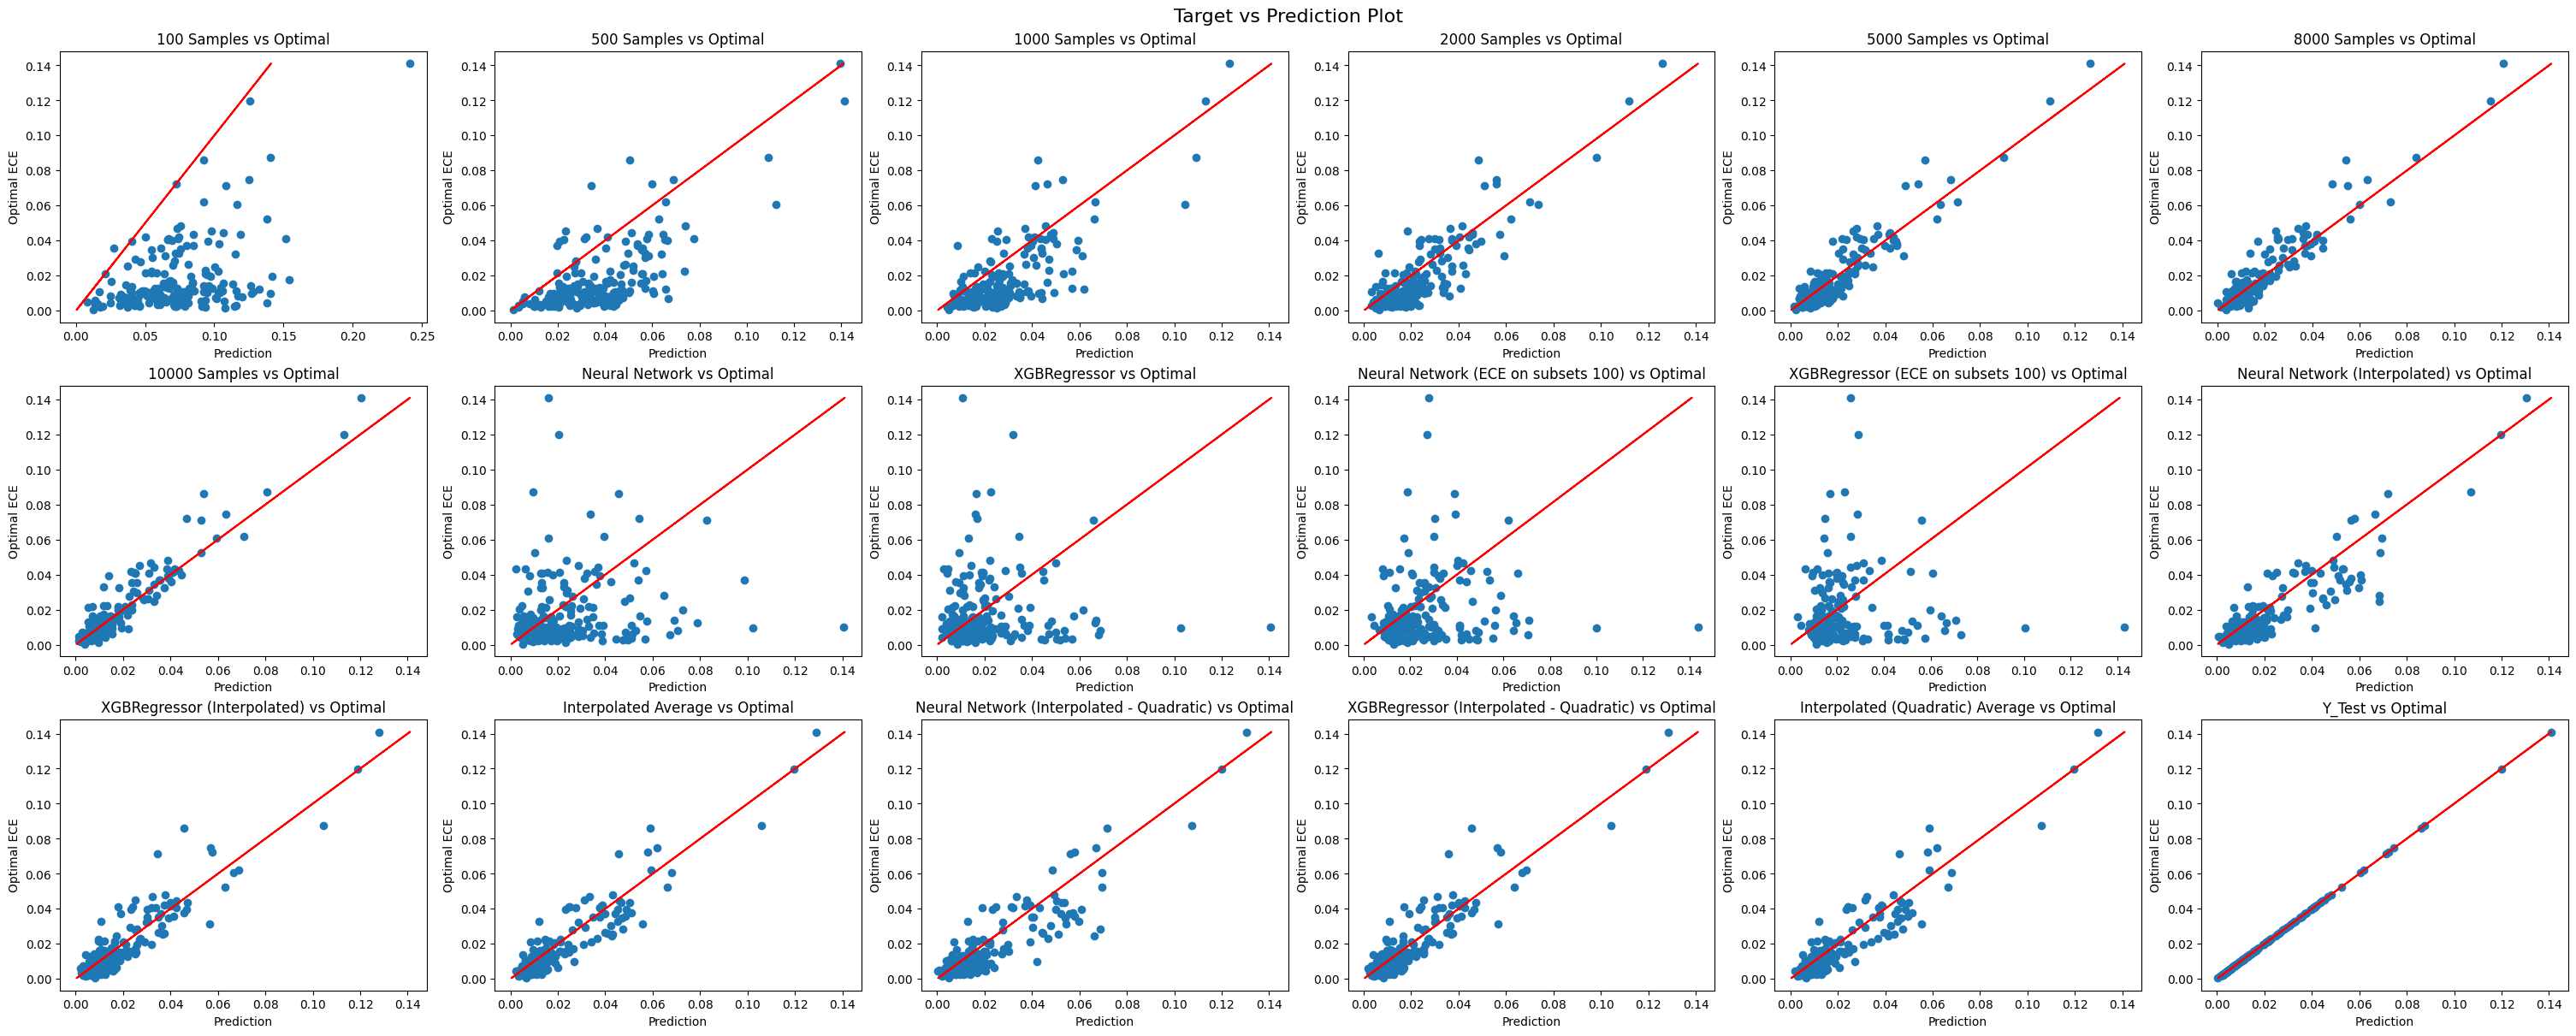

In [45]:
num_preds = len(preds)
cols = 6
rows = int(np.ceil(num_preds / cols))

fig, axs = plt.subplots(rows, cols, figsize=(30, 4 * rows), constrained_layout=True)
axs = axs.flatten()

for i, (key, value) in enumerate(preds.items()):
    ax = axs[i]
    if len(value) > 1:
        ax.scatter(value[1], optimal_eces_test)
        ax.plot(optimal_eces_test, optimal_eces_test, c='red')
        ax.set_title(f"{key} vs Optimal")
        ax.set_xlabel("Prediction")
        ax.set_ylabel("Optimal ECE")

# Hide unused subplots if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Target vs Prediction Plot", fontsize=16)
plt.savefig("./optimal_ece_estimator_reliability_diagrams")
plt.show()